In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime

In [2]:
current_time = datetime.now()

# Format the time as "Hour:Minute AM/PM"
formatted_time = current_time.strftime("%I:%M %p")

print("Formatted time:", formatted_time)


Formatted time: 09:13 PM


In [3]:
# read
# n_LF, n_HF, rel_error = np.loadtxt('error_function_11P_MF-Box.txt', unpack=True, usecols=(0,1,2))
n_LF, n_HF, rel_error = np.loadtxt('error_function_Frontera.txt', unpack=True, usecols=(0,1,2))

In [4]:
rel_error.shape

(540,)

In [5]:
def grid_error(n_LF, n_HF, rel_error, n_LF_max = 270, n_HF_max = 9, len_slice = 3):
    X_grid = int(n_LF_max / len_slice)
    Y_grid = int(n_HF_max / len_slice)
    grid_error = np.ones((X_grid, Y_grid))
    n_sample = np.ones((X_grid, Y_grid))
    x = n_HF/len_slice
    y = n_LF/len_slice
    for i in range(len(x)):
        i_y = int(x[i]) - 1
        i_x = int(y[i]) - 1
        if grid_error[i_x, i_y] != 1:
            grid_error[i_x, i_y] += rel_error[i]
            n_sample[i_x, i_y] += 1
        else:
            grid_error[i_x, i_y] = rel_error[i]

    grid_error = grid_error/n_sample
    return grid_error

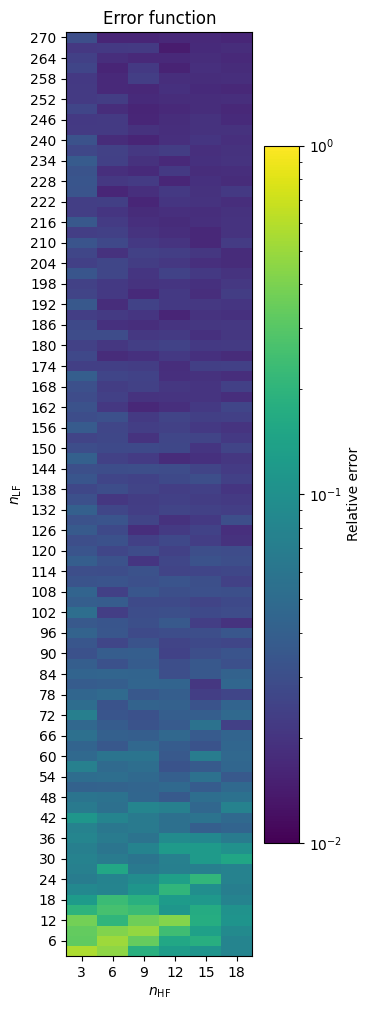

In [6]:
n_LF_max = 270
n_HF_max = 18
len_slice = 3

y = np.linspace(len_slice, n_LF_max, n_LF_max//len_slice)  # Replace with your desired range and resolution
x = np.linspace(len_slice, n_HF_max, n_HF_max//len_slice)  # Replace with your desired range and resolution
X, Y = np.meshgrid(x, y)

# create griddata
Z = grid_error(n_LF, n_HF, rel_error, len_slice=len_slice, n_LF_max=n_LF_max, n_HF_max=n_HF_max)

# Create a colormap to map function values to colors
cmap = plt.get_cmap('viridis')
vmin = 1e-2
vmax = 1

# Create a plot
plt.figure(figsize=(3, 12))
plt.pcolormesh(X, Y, Z, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar(label='Relative error')
plt.title('Error function')
plt.xlabel(r'$n_\mathrm{HF}$')
plt.ylabel(r'$n_\mathrm{LF}$')
xticks = np.arange(3, n_HF_max + 1, 3)
plt.xticks(xticks)
y_ticks = np.arange(6, n_LF_max + 1, 6)
plt.yticks(y_ticks)
plt.show()


In [7]:
def get_pairs_done(output_file):
    pairs_done = np.loadtxt(output_file, usecols=(0,1))
    return pairs_done

In [8]:
pairs_done = get_pairs_done('error_function.txt')

In [9]:
pairs_done

array([[ 12.,   9.],
       [ 12.,  12.],
       [ 12.,   6.],
       ...,
       [270.,   3.],
       [267.,   3.],
       [ 12.,   3.]])

In [16]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 9.180582707595432
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 0.2043253342838957
    beta_L = 1.1851555212967242
    beta_H = 0.6769375801601656
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 1.9693465099568148
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 10.336437586660763
    alpha_1 = 9.148634792876067
    alpha_2 = 20.68057204828696

    sigma_lg_Phi = 0.09505097667012101   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return mean_Phi

In [17]:
error_function(500,22)

0.009315295492980848

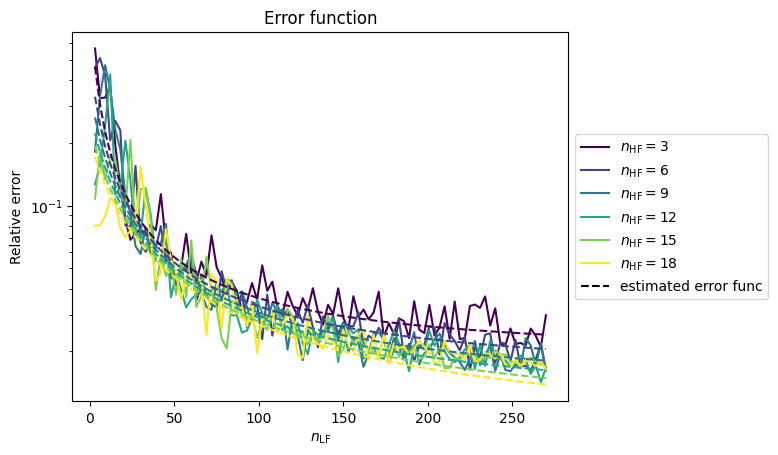

In [18]:
# distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(X[0])))

# plot the error function as curves
for i in range(len(X[0])):
    plt.plot(Y[:,0], Z[:, i], color=colors[i],label=r'$n_\mathrm{HF}=$' + str(int(X[0, i])))
# plot the error function as curves for different n_HF
for i in range(len(X[0])):
    plt.plot(Y[:,0], error_function(Y[:,0], X[0,i]), '--', color=colors[i])

plt.plot([],[], 'k--', label='estimated error func')
# adjust the legend location to outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.yscale('log')
# plt.ylim(1e-3, 2)
plt.xlabel(r'$n_\mathrm{LF}$')
plt.ylabel('Relative error')
plt.title('Error function')
plt.show()

In [19]:
# naive lg_Phi
def error_function_naive(n_LF, n_HF):
    eta = 0.03581626191669149
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 21.927914418631985
    beta_L = 0.7371516706710961
    beta_H = 1.1997988599277738

    sigma_lg_Phi = 0.10670526031601629   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / (n_LF**(beta_L)) + 1 / (n_HF**(beta_H)))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return mean_Phi

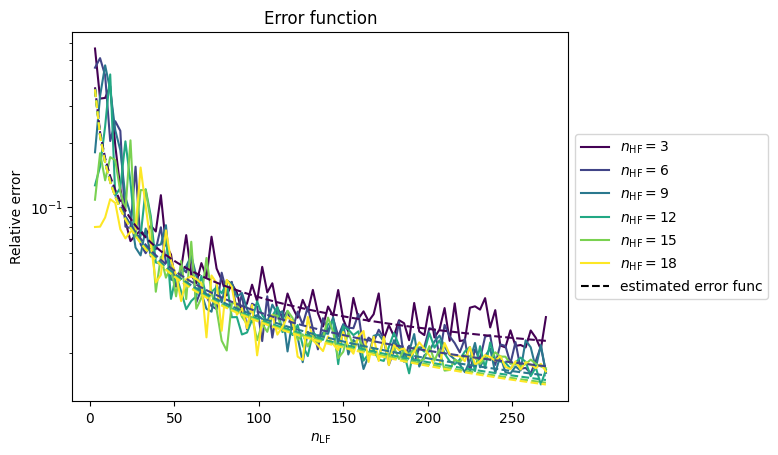

In [20]:
# distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(X[0])))

# plot the error function as curves
for i in range(len(X[0])):
    plt.plot(Y[:,0], Z[:, i], color=colors[i],label=r'$n_\mathrm{HF}=$' + str(int(X[0, i])))
# plot the error function as curves for different n_HF
for i in range(len(X[0])):
    plt.plot(Y[:,0], error_function_naive(Y[:,0], X[0,i]), '--', color=colors[i])

plt.plot([],[], 'k--', label='estimated error func')
# adjust the legend location to outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.yscale('log')
# plt.ylim(1e-3, 2)
plt.xlabel(r'$n_\mathrm{LF}$')
plt.ylabel('Relative error')
plt.title('Error function')
plt.show()